**Author:** Boris Kundu

**Problem Statement:** Comparison of attention pooling techniques

**Dataset:** COVID-19 hospitalizations

In [214]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline

In [215]:
#Read data
data = np.genfromtxt('hospitalizations.txt', delimiter=' ')
hosp = data[:,1]

In [216]:
#Standardize
mean = np.mean(hosp, axis=0)
std = np.std(hosp, axis=0)
hosp = (hosp - mean)/std

In [217]:
#Initial params
last = len(hosp)
seqlen = 20 # input size or window size
batchsize = 50 # data period and number of data points
trainbegin = np.random.randint(400)

In [218]:
#Prep training set
Xtrain = hosp[trainbegin:trainbegin+seqlen]
ytrain = hosp[trainbegin+seqlen]
for i in range(1, batchsize):
    Xtrain = np.vstack([Xtrain, hosp[trainbegin+i:trainbegin+i+seqlen]])
    ytrain = np.append(ytrain, hosp[trainbegin+i+seqlen])

In [219]:
#Define features
X = torch.tensor(Xtrain, dtype=torch.float)
y = torch.tensor(ytrain, dtype=torch.float)

In [220]:
#Sytsem params
inputsize = 1
outputsize = 1

In [221]:
X2 = torch.reshape(X, (batchsize, inputsize, seqlen))

In [222]:
#Average attention pooling
class Model(nn.Module):
    def __init__(self, seqlen):
        super(Model, self).__init__()
        self.pool = nn.AvgPool1d(seqlen)

    def forward(self, x):
        return self.pool(x)[:, 0, 0]

In [223]:
model = Model(seqlen)
yhat_avg_att = model(X2)
L = F.mse_loss(yhat_avg_att, y)
print(f'Average Attention Pooling Loss: {L.item()}')

Average Attention Pooling Loss: 0.028843145817518234


In [224]:
#Nadaraya-Watson kernel-regression/attention-pooling
class Model(nn.Module):
    def __init__(self, seqlen):
        super(Model, self).__init__()
        self.attention = torch.tensor(np.empty(seqlen), dtype=torch.float)

    def forward(self, x):
        for i in range(seqlen):
            d = seqlen - i
            self.attention[i] = -d * d / 2.0
        self.attention = F.softmax(self.attention, dim=0)
        return x.matmul(self.attention)

In [225]:
model = Model(seqlen)
yhat_nw_att = model(X)
L = F.mse_loss(yhat_nw_att, y)
print(f'Nadaraya-Watson Kernel-regression/Attention-pooling Loss: {L.item()}')

Nadaraya-Watson Kernel-regression/Attention-pooling Loss: 0.0006416458636522293


In [226]:
# Nadaraya-Watson attention pooling with trainable weights
class Model(nn.Module):
    def __init__(self, seqlen):
        super(Model, self).__init__()
        att = np.empty(seqlen)
        for i in range(seqlen):
            att[i] = (seqlen - i) * (seqlen - i)
        self.attention = torch.tensor(att, dtype=torch.float, requires_grad=True)
        self.w = nn.parameter.Parameter(torch.empty(1), requires_grad=True)
    def forward(self, x):
        att2 = -self.attention * self.w
        att3 = F.softmax(att2, dim=0)
        return x.matmul(att3)

In [227]:
epochs = 1000

In [228]:
model = Model(seqlen)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
for i in range(epochs):
    yhat_nw_att_tw = model(X)
    L = F.mse_loss(yhat_nw_att_tw, y)
    if(i%100 == 0):
        print(f'Nadaraya-Watson weighted attention pooling Epoch:{i+1} with Loss:{L.item()} and Weight:{model.w.data.item()}')
    optimizer.zero_grad()
    L.backward()
    optimizer.step()

Nadaraya-Watson weighted attention pooling Epoch:1 with Loss:0.0038811347912997007 and Weight:0.028843145817518234
Nadaraya-Watson weighted attention pooling Epoch:101 with Loss:0.0020085005089640617 and Weight:0.06878980249166489
Nadaraya-Watson weighted attention pooling Epoch:201 with Loss:0.0017318942118436098 and Weight:0.08566858619451523
Nadaraya-Watson weighted attention pooling Epoch:301 with Loss:0.001589156687259674 and Weight:0.09773268550634384
Nadaraya-Watson weighted attention pooling Epoch:401 with Loss:0.001495177624747157 and Weight:0.10749701410531998
Nadaraya-Watson weighted attention pooling Epoch:501 with Loss:0.0014261974720284343 and Weight:0.11585140228271484
Nadaraya-Watson weighted attention pooling Epoch:601 with Loss:0.0013722390867769718 and Weight:0.12323242425918579
Nadaraya-Watson weighted attention pooling Epoch:701 with Loss:0.001328273443505168 and Weight:0.1298915594816208
Nadaraya-Watson weighted attention pooling Epoch:801 with Loss:0.001291344291

In [229]:
hiddensize = 10

In [230]:
# Additive attention with trainable weight
class Model(nn.Module):
    def __init__(self, hiddensize, seqlen):
        super(Model, self).__init__()
        keys = np.empty(seqlen)
        for i in range(seqlen):
            keys[i] = i + 1
        self.K = torch.tensor(keys, dtype=torch.float)
        self.wk = nn.parameter.Parameter(torch.randn(hiddensize), requires_grad=True)
        self.wv = nn.parameter.Parameter(torch.randn(hiddensize), requires_grad=True)

    def forward(self, x):
        att1 = torch.tanh(torch.outer(self.K, self.wk))
        att2 = att1.matmul(self.wv)
        att3 = F.softmax(att2, dim=0)
        return x.matmul(att3)

In [231]:
model = Model(hiddensize, seqlen)

In [232]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [233]:
for i in range(epochs):
    yhat_add_att_tw = model(X)
    L = F.mse_loss(yhat_add_att_tw, y)
    if(i%100 == 0):
        print(f'Additive weighted attention pooling Epoch:{i+1} with Loss:{L.item()}')
    optimizer.zero_grad()
    L.backward()
    optimizer.step()

Additive weighted attention pooling Epoch:1 with Loss:0.022294223308563232
Additive weighted attention pooling Epoch:101 with Loss:0.01864500716328621
Additive weighted attention pooling Epoch:201 with Loss:0.017918378114700317
Additive weighted attention pooling Epoch:301 with Loss:0.017465274780988693
Additive weighted attention pooling Epoch:401 with Loss:0.0170258991420269
Additive weighted attention pooling Epoch:501 with Loss:0.01659269630908966
Additive weighted attention pooling Epoch:601 with Loss:0.016153553500771523
Additive weighted attention pooling Epoch:701 with Loss:0.015683921054005623
Additive weighted attention pooling Epoch:801 with Loss:0.015117751434445381
Additive weighted attention pooling Epoch:901 with Loss:0.014164038002490997


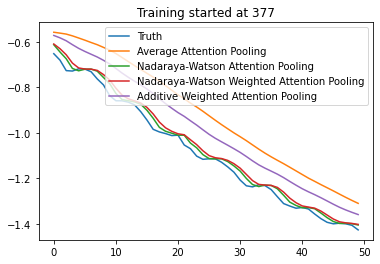

In [234]:
#Plot to compare models
plt.plot(y.detach().numpy())
plt.plot(yhat_avg_att.detach().numpy())
plt.plot(yhat_nw_att.detach().numpy())
plt.plot(yhat_nw_att_tw.detach().numpy())
plt.plot(yhat_add_att_tw.detach().numpy())
plt.legend(['Truth','Average Attention Pooling','Nadaraya-Watson Attention Pooling','Nadaraya-Watson Weighted Attention Pooling','Additive Weighted Attention Pooling'])
plt.title('Training started at ' + str(trainbegin))
plt.show()